In [160]:
#packages
import pandas as pd
import sklearn # make sure this is installed in your environment.
from sklearn.datasets import *
from sklearn import tree
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import math
from sklearn.model_selection import StratifiedShuffleSplit
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV

from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from typing import Tuple
from sklearn.model_selection import KFold
import math
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import OPTICS
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.feature_selection import VarianceThreshold

In [5]:
#dummies
df = pd.read_csv(r'Mid07new_with_dist1_dist10_small.txt',sep=',')
df = df[['realprice1', 'realprice2', 'realprice3', 'realprice4',
       'br1', 'br2', 'br3', 'br4', 'residual.price.1', 'residual.price.2',
       'residual.price.3', 'residual.price.4','TRADEMANUFACTURER',
       'TRADENAME', 'TRADEMODEL', 'TRADEORIGIN', 'TRADEBODYTP',
       'TRADECYLINDER',"CUSTLATITUDE","CUSTLONGITUDE",'ZIPCODE','brand']].copy()
df = pd.get_dummies(df,drop_first=True)

In [195]:
df = df[['ZIPCODE','brand']].copy()

In [205]:
df = df.drop(["CUSTLATITUDE","CUSTLONGITUDE",'ZIPCODE'], axis=1)

In [209]:
#split
X = df.drop(['brand'], axis=1)
y = df.brand
def StratifiedSampling(df, test_size):
    X = df.drop(['brand'], axis=1)
    y = df.brand
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)    
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
    return train,test
train,test = StratifiedSampling(df, 0.2)
X_train = train.drop(['brand'], axis=1)
y_train = train.brand
X_test = test.drop(['brand'], axis=1)
y_test = test.brand

In [27]:
def MAD(pred_prob,y_test):
    MAD_list=[]
    for i in range(len(y_test)):
        mad_row = [1-n if j==y_test[i]-1 else n for j, n in enumerate(pred_prob[i]) ]
        MAD_list.append(sum(mad_row))
    return sum(MAD_list)/len(MAD_list)

In [193]:
y_comp = y_test.copy()

## ZNN

In [184]:
#ZNN
zip_dict = train.groupby('ZIPCODE')['brand'].apply(list).to_dict()
pred_prob,fin_pred,_01mad = [],[],[]
test_list = []
for z in X_test.ZIPCODE:
    if z in zip_dict:
        b_list = zip_dict.get(z)
        b_prob = [float(b_list.count(i))/len(b_list) for i in [1,2,3,4]] #prob distribution for each brand
        pred_label = b_prob.index(max(b_prob))+1
        test_list.append(0)
    else:
        b_prob = [0.25,0.25,0.25,0.25]
        pred_label = 0
        test_list.append(1)
    pred_prob.append(b_prob) 
    fin_pred.append(pred_label) 
    pred_label_list = [0]*4
    pred_label_list[pred_label-1]=1
    _01mad.append(pred_label_list)

In [185]:
#ZNN score
new_p,new_y,new_prob,new_01=[],[],[],[]
for i,j,h,m in zip(fin_pred,y_test,pred_prob,_01mad):
    if i != 0:
        new_p.append(i)
        new_y.append(j)
        new_prob.append(h)
        new_01.append(m)
print('0or1MAD: ', round(MAD(new_01,list(new_y)),2))
print('normMAD: ', round(MAD(new_prob,list(new_y)),2))
print('accuracy: ', round(accuracy_score(new_y, new_p),2))

0or1MAD:  0.88
normMAD:  0.93
accuracy:  0.56


## Lat Long  NN

In [6]:
df = df[["CUSTLATITUDE","CUSTLONGITUDE",'brand']].copy()

In [198]:
def haversine_distance(lat1,lon1,lat2,lon2):
    R = 6371e3; #metres
    φ1 = lat1 * math.pi/180; # φ, λ in radians
    φ2 = lat2 * math.pi/180;
    Δφ = (lat2-lat1) * math.pi/180;
    Δλ = (lon2-lon1) * math.pi/180;

    a = math.sin(Δφ/2) * math.sin(Δφ/2) +math.cos(φ1) * math.cos(φ2) *math.sin(Δλ/2) * math.sin(Δλ/2);
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a));
    d = R * c; # in metres\
    return d

In [212]:
label_list,fin_list=[],[]
for lat1,lon1 in zip(X_test.CUSTLATITUDE, X_test.CUSTLONGITUDE):
    min_d =  float('inf')
    for lat2,lon2,l in zip(X_train.CUSTLATITUDE, X_train.CUSTLONGITUDE,y_train):
        d = haversine_distance(lat1,lon1,lat2,lon2)
        if d < min_d:
            min_d = d
            min_label_list = [l]
        elif d == min_d:
            min_label_list.append(l)
    pred_label_list = [0]*4
    pred_label_list[min_label_list[0]-1]=1
    label_list.append(min_label_list[0])
    fin_list.append(pred_label_list)

In [213]:
print('0or1MAD: ', round(MAD(fin_list,list(y_test)),2))
print('accuracy: ', round(accuracy_score(y_test, label_list),2))

0or1MAD:  0.86
accuracy:  0.57


In [225]:
y_comp['latlong']=pd.DataFrame(label_list)

## Cluster

In [228]:
#load and prepare data
df = pd.read_csv(r'Mid07new_with_dist1_dist10_small.txt',sep=',')
df = df[['realprice1', 'realprice2', 'realprice3', 'realprice4',
       'br1', 'br2', 'br3', 'br4', 'residual.price.1', 'residual.price.2',
       'residual.price.3', 'residual.price.4','TRADEMANUFACTURER',
       'TRADENAME', 'TRADEMODEL', 'TRADEORIGIN', 'TRADEBODYTP',
       'TRADECYLINDER',"CUSTLATITUDE","CUSTLONGITUDE",'ZIPCODE','brand']].copy()
df = pd.get_dummies(df,drop_first=True)
df = df.drop(["CUSTLATITUDE","CUSTLONGITUDE",'ZIPCODE'], axis=1)
##split
X = df.drop(['brand'], axis=1)
y = df.brand

In [229]:
#LA dataset
df_LA = pd.read_csv(r'LA07 (2019 0612) with DIST1.txt',sep=' ')
df_LA = df_LA[['realprice1', 'realprice2', 'realprice3', 'realprice4',
       'br1', 'br2', 'br3', 'br4', 'X1', 'X2',
       'X3', 'X4','TRADEMANUFACTURER',
       'TRADENAME', 'TRADEMODEL', 'TRADEORIGIN', 'TRADEBODYTP',
       'TRADECYLINDER','brand']].copy()
df_LA=df_LA.rename(columns = {'X1':'residual.price.1','X2':'residual.price.2','X3':'residual.price.3','X4':'residual.price.4'})

##concat
df_LA = pd.get_dummies(df_LA,drop_first=True)
col_list = (df_LA.append([df])).columns.tolist()
df = df.reindex(columns=col_list, fill_value=0)
df_LA = df_LA.reindex(columns=col_list, fill_value=0)
#df = pd.concat([df,df_LA]).reset_index()
df = df_LA.copy()
##split
X = df.drop(['brand'], axis=1)
y = df.brand

In [223]:
y

0       3
1       1
2       1
3       3
4       1
       ..
3300    2
3301    1
3302    2
3303    2
3304    2
Name: brand, Length: 3305, dtype: int64

In [230]:
#PCA
df_result = pd.DataFrame()
df_result['scores'] = ['0or1MAD','normMAD','accuracy']

for n in [10,30,50,100]:
    pca = PCA(n_components=n).fit(X)
    #pca = IncrementalPCA(n_components=n).fit(X)
    #sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
    X_sel = pd.DataFrame(pca.transform(X))
    #X_sel = pd.DataFrame(sel.fit_transform(X))
    X_sel = get_clusters(X_sel,'AffinityPropagation',7)
    df_pca = X_sel.copy()
    df_pca['brand'] = y
    cluster_dict = df_pca.groupby('clusters')['brand'].apply(list).to_dict()
    X_train,y_train,X_test,y_test = StratifiedSampling(df_pca, 0.2)
    pred_prob,fin_pred,_01mad = cluster_predict(X_test,cluster_dict)
    df_result[n] = [round(MAD(_01mad,list(y_test)),2),round(MAD(pred_prob,list(y_test)),2),round(accuracy_score(y_test, fin_pred),2)]

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
df_result.set_index('scores')

In [222]:
df_result.set_index('scores')

,100
scores,
0or1MAD,1.13
normMAD,1.33
accuracy,0.44


In [195]:
def train_model(X, model, n_clusters):
    if model == 'kmean':
        clustering = KMeans(n_clusters=n_clusters, random_state=42)
    if model == 'AffinityPropagation':
        clustering = AffinityPropagation(damping=0.9, random_state=42,max_iter=4000)    
    if model == 'AgglomerativeClustering':
        clustering = AgglomerativeClustering(n_clusters=9)
    if model == 'Birch':
        clustering = Birch(threshold=0.01, n_clusters=9)
    if model == 'DBSCAN':
        clustering = DBSCAN(eps=0.30, min_samples=9)    
    if model == 'MiniBatchKMeans':
        clustering = MiniBatchKMeans(n_clusters=n_clusters)       
    if model == 'MeanShift':
        clustering = MeanShift()
    if model == 'OPTICS':
        clustering = OPTICS(eps=0.8, min_samples=10)   
    if model == 'SpectralClustering':
        clustering = SpectralClustering(n_clusters=7)
    if model == 'GaussianMixture':
        clustering = GaussianMixture(n_components=7)
    clustering.fit(X)
    return clustering 

In [11]:
def get_clusters(X, model, n_clusters) -> Tuple[pd.DataFrame, pd.DataFrame]:
    clustering = train_model(X, model, n_clusters)
    # apply the labels
    train_labels = clustering.labels_
    X_clstrs = X.copy()
    X_clstrs['clusters'] = train_labels
    return X_clstrs

In [23]:
#split
def StratifiedSampling(df, test_size):
    X = df.drop(['brand'], axis=1)
    y = df.brand
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=0)    
    sss.get_n_splits(X, y)
    for train_index, test_index in sss.split(X, y):
        train = df.iloc[train_index,:]
        test = df.iloc[test_index,:]
    X_train = train.drop(['brand'], axis=1)
    y_train = train.brand
    X_test = test.drop(['brand'], axis=1)
    y_test = test.brand
    return X_train,y_train,X_test,y_test

In [24]:
def cluster_predict(X_test,cluster_dict):
    pred_prob,fin_pred,_01mad = [],[],[]
    for z in X_test.clusters:
        b_list = cluster_dict.get(z)
        b_prob = [float(b_list.count(i))/len(b_list) for i in [1,2,3,4]] #prob distribution for each brand
        pred_label = b_prob.index(max(b_prob))+1
        pred_label_list = [0]*4
        pred_label_list[pred_label-1]=1
    
        pred_prob.append(b_prob) 
        fin_pred.append(pred_label) 
        _01mad.append(pred_label_list)
    return pred_prob,fin_pred,_01mad

In [82]:
cluster_methods = ['kmean','AffinityPropagation','AgglomerativeClustering','Birch','DBSCAN','MiniBatchKMeans','SpectralClustering']

In [92]:
cluster_methods = ['AgglomerativeClustering']

In [106]:
df_result = pd.DataFrame()
df_result['scores'] = ['0or1MAD','normMAD','accuracy']
for i in cluster_methods:
    X= get_clusters(X,i,7)
    df['clusters'] = X.clusters
    cluster_dict = df.groupby('clusters')['brand'].apply(list).to_dict()
    X_train,y_train,X_test,y_test = StratifiedSampling(df, 0.2)
    pred_prob,fin_pred,_01mad = cluster_predict(X_test,cluster_dict)
    df_result[i] = [round(MAD(_01mad,list(y_test)),2),round(MAD(pred_prob,list(y_test)),2),round(accuracy_score(y_test, fin_pred),2)]
#    print(i)
#    print('0or1MAD: ', round(MAD(_01mad,list(y_test)),2))
#    print('normMAD: ', round(MAD(pred_prob,list(y_test)),2))
#    print('accuracy: ', round(accuracy_score(y_test, fin_pred),2))

In [107]:
df_result.set_index('scores')

,Birch
scores,
0or1MAD,0.72
normMAD,0.95
accuracy,0.64


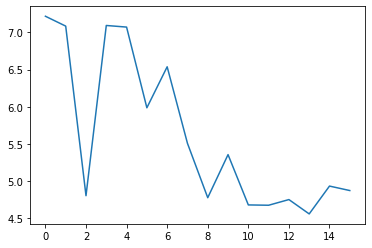

In [78]:
def calculate_WSS(points, kmax):
    sse = []
    for k in range(1, kmax+1):
        clustering = train_model(X, 'MiniBatchKMeans', k)
        centroids = clustering.cluster_centers_
        pred_clusters = clustering.predict(points)
        curr_sse = 0
    
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
        for i in range(len(points)):
            curr_center = centroids[pred_clusters[i]]
            sse1 = (points.iloc[i, 0] - curr_center[0]) ** 2 
            sse2 = (points.iloc[i, 1] - curr_center[1]) ** 2
            curr_sse += sse1+sse2
      
        sse.append(curr_sse)
    return sse
result = calculate_WSS(X, 16)
plt.plot(result)

In [226]:
y_comp['cluster']=pd.DataFrame(fin_pred)

In [227]:
pd.DataFrame(y_comp)

,brand
321,3
676,3
722,3
329,1
790,1
...,...
52,2
757,3
543,1
latlong,0 0 1 1 2 2 1 3 3 4 3 .. ...
